# Generate Training data for KSS events (speech/no speech)

Once generated the training data is saved.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Data Preparation
Create features and labels


### Character and Syllable Chunk Markers


In [7]:
from kss_chunk import KssChunk

from marker_df import MarkerDf
# # disp.file_source('marker_df.py', label='marker_df.py ')
#
# chunk_dir = 'data/korean-single-speaker/kss_chunks'
#
# markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
# markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')
markers_char_df, markers_syl_df = KssChunk.load_all()
markers_char = MarkerDf(markers_char_df)
markers_syl = MarkerDf(markers_syl_df)

### Event Markers

#### Event Marker Data

In [8]:
disp.obj(markers_char.df, 'Character DataFrame')
disp.obj(markers_char.df.describe(), 'Character DataFrame Statistics')
disp.obj(markers_syl.df, 'Syllable DataFrame')
disp.obj(markers_syl.df.describe(), 'Syllable DataFrame Statistics')


Character DataFrame

,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
12,아,0.91879,1.07637,data/korean-single-speaker/kss/1/1_0005.wav
13,ᄉ,1.07637,1.18436,data/korean-single-speaker/kss/1/1_0005.wav
14,ᅦ,1.18436,1.28889,data/korean-single-speaker/kss/1/1_0005.wav
15,요?,1.28889,1.44689,data/korean-single-speaker/kss/1/1_0005.wav


Character DataFrame Statistics

,start,stop
count,167.000000,167.000000
mean,1.254125,1.341464
std,0.964133,0.974697
min,0.000000,0.042620
25%,0.495740,0.570495
50%,1.021230,1.094440
75%,1.864210,1.987870
max,3.713270,3.972180


Syllable DataFrame

,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
7,잘,0.67573,0.91961,data/korean-single-speaker/kss/1/1_0005.wav
8,아,0.91961,1.07637,data/korean-single-speaker/kss/1/1_0005.wav
9,세,1.07637,1.28889,data/korean-single-speaker/kss/1/1_0005.wav
10,요?,1.28889,1.44689,data/korean-single-speaker/kss/1/1_0005.wav


Syllable DataFrame Statistics

,start,stop
count,95.000000,95.000000
mean,1.172032,1.325565
std,0.954730,0.981267
min,0.000000,0.042620
25%,0.402540,0.556215
50%,0.987470,1.077370
75%,1.655010,1.764465
max,3.713270,3.972180


#### Intervals

In [4]:
disp.obj(markers_char.intervals(), 'Char Intervals')
disp.obj(markers_char.intervals().describe(), 'Char Interval statistics')
disp.obj(markers_syl.intervals(), 'Syl Intervals')
disp.obj(markers_syl.intervals().describe(), 'Syl Interval statistics')

Char Intervals

0      0.14298
1      0.03028
2      0.07817
3      0.04967
4      0.09346
        ...   
161    0.15758
162    0.10799
163    0.10453
164    0.15800
165    0.03919
Length: 166, dtype: float64

Char Interval statistics

count    166.000000
mean       0.085031
std        0.058785
min        0.006800
25%        0.043677
50%        0.072920
75%        0.109245
max        0.312600
dtype: float64

Syl Intervals

0     0.14298
1     0.10845
2     0.24330
3     0.02924
4     0.19449
       ...   
89    0.24388
90    0.15676
91    0.21252
92    0.15800
93    0.03919
Length: 94, dtype: float64

Syl Interval statistics

count    94.000000
mean      0.150161
std       0.079240
min       0.012280
25%       0.092797
50%       0.145810
75%       0.210795
max       0.336930
dtype: float64

### Features and Labels

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec

#### Labels

True/False  Speech/No Speech

#### Features

Base waveform: RMS calculation (via librosa) of audio wav file
This significantly reduces the feature space with little impact to learning

Features are a sliding window on the base RMS waveform.

#### Mapping Label to Feature

It's easier to understand visually:

For a Sliding Window size = 16
```
     Sliding Window[6]           sliding_window[6].shape = (16,)
 012345 6789012345678901 2345678  index visualization
 ------|----------------|-------  waveform
                   |
                   V              y-offset = 11
 000000 0000000011111111 1111000  speech/no speech labels
                   1              label corresponding to sliding_window[6] -> label[17]


Mapping of sliding window to label
sliding_window[0]  -> 0 label[11]
sliding_window[1]  -> 0 label[12]
sliding_window[2]  -> 1 label[13]
sliding_window[3]  -> 1 label[14]
sliding_window[4]  -> 1 label[15]
sliding_window[5]  -> 1 label[16]
sliding_window[6]  -> 1 label[17]
sliding_window[7]  -> 1 label[18]
...
sliding_window[11] -> 1 label[24]
sliding_window[12] -> 1 label[25]
sliding_window[13] -> 0 label[26]
sliding_window[14] -> 0 label[27]
...
```

For our speech analysis, what comes after does have an effect on the present, but the past has more of
an impact. So say for this example, we look behind 11 points, and look ahead 4 points. This gives us a total window
size of 16 points (since we include our current point). So our sliding window has a size of 16.

So for the very first sliding window,

`window[0]` has `waveform[0:15]` and the associated label is `label[11]` -> `0 [Speech Not Present]`.

As we continue to slide the window, say 6 more times,

`window[6]` -> `waveform[17]` -> `label[17]` -> `1 [Speech Present]`.

This will generate our `y` that we want the window data to predict. So

```
X (feature)                 |  y (label)
window[0] = waveform[0:16]  |  y[0] = label[11] = 0
window[1] = waveform[1:17]  |  y[1] = label[12] = 0
window[2] = waveform[2:18]  |  y[2] = label[13] = 1
window[3] = waveform[3:19]  |  y[3] = label[14] = 1
window[4] = waveform[4:20]  |  y[4] = label[15] = 1
...
```

Note that the `y` we predict will be offset from the actual waveform by our "look behind" of 11 points. This is
the "y-offset". So later after we predict `y`, we will need to shift it by `y-offset` to align it with the
original labels and waveform.

### Feature Prep and Inspection

Generate the Feature data (X)


#### AudioPlexer Usage and Inspection

AudioPlexer will be used to generate the Feature (X) data.
Use `audio_plexer.ipynb` and `audio.ipynb` to explore AudioPlexer and Audio classes.

## Training

### Generate Training Features

Generate Training Features to be used for training our model

TODO: Incorporate MFCCs

In [9]:
training_files= markers_syl.df['audio'].unique()

disp.obj(training_files, 'Training Files')
#TODO: split training files into a validation hold out set.

Training Files

array(['data/korean-single-speaker/kss/1/1_0000.wav',
       'data/korean-single-speaker/kss/1/1_0001.wav',
       'data/korean-single-speaker/kss/1/1_0002.wav',
       'data/korean-single-speaker/kss/1/1_0003.wav',
       'data/korean-single-speaker/kss/1/1_0004.wav',
       'data/korean-single-speaker/kss/1/1_0005.wav'], dtype=object)

In [11]:
from audio_plexer import AudioPlexer


ap_params_train = {
    'n_fft': 256,
    'n_hops':  4,
    'sliding_window_size': 128,
    'sliding_offset': 64
}

# AudioPlexer will take the training files and allow for wav form manipulations.
ap = AudioPlexer(training_files, **ap_params_train)

print(f'all audio length (wav samples) {ap.size}, duration: {ap.size/ap.sr}')
ap_rms = ap.rms().flatten()

is_speech_wav = ap.speech_from_interval(markers_syl.df, missing_val=False)
is_speech_rms = ap.to_rms(is_speech_wav.astype(float)).flatten()


print(f'wav shape: {ap.wav().shape}')
print(f'wav rms shape: {ap_rms.shape}')
print(f'is_speech_wav shape: {is_speech_wav.shape}')
print(f'is_speech_rms shape: {is_speech_rms.shape}')

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2430, reduced 2429.984375
Audio[WARNING]: Modifying input wav from size 175173 to 175168
Audio[INFO]: change in number of samples: -5 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2737, reduced 2736.984375
Audio[WARNING]: Modifying input wav from size 77573 to 77568
Audio[INFO]: change in number of samples: -5 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1212, reduced 1211.984375
Audio[WARNING]: Modifying input wav from size 101762 to 101760
Audio[INFO]: change in number of samples: -2 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1590, reduced 1589.984375
Audio[WARNING]: Modifying input wav from size 58741 to 58688
Audio[INFO]: chan

all audio length (wav samples) 643130, duration: 14.58344671201814
wav shape: (643130,)
wav rms shape: (10049,)
is_speech_wav shape: (643130,)
is_speech_rms shape: (10049,)


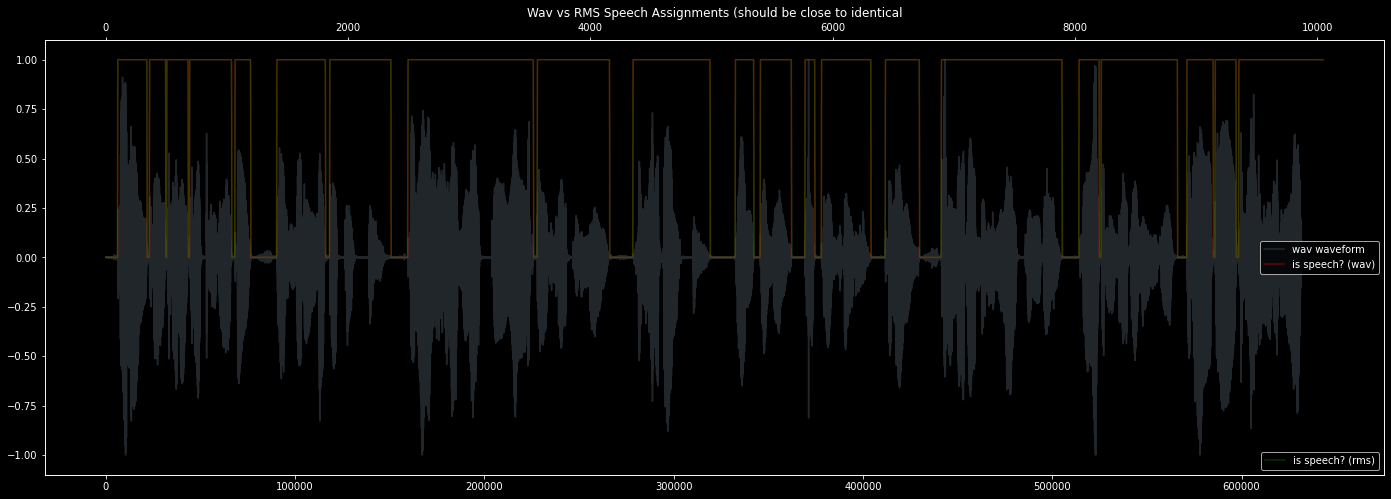

In [16]:
# TODO: Add wav and rms to this plot
fig, ax1  = plt.subplots(1, 1, figsize=(24,8))
# fig.suptitle('RMS X and y', fontsize=14)

ax1.set_title(f'Wav vs RMS Speech Assignments (should be close to identical')
ax1.plot(ap.wav(), color='slategray', alpha=0.3, label='wav waveform')
ax1.plot(is_speech_wav.astype(float), color='red', alpha=0.4, label='is speech? (wav)')
ax1.legend(loc='center right')
ax1a = ax1.twiny()
ax1a.plot(is_speech_rms, color='green', alpha=0.4, label='is speech? (rms)')
ax1a.legend(loc='lower right')

plt.show()

disp.audio(data=ap.wav(), rate=ap.sr)

In [13]:
# # TODO: Use these functions to create and assign value column (as float) rather than in the Audio* classes
# def filter_to_basics(full_df, filter_on_path):
#     return full_df.loc[full_df['audio'] == filter_on_path,['start', 'stop', 'syl', 'audio']]
#
# def flag_speech(df):
#     df['value'] = df['syl'] != '0'
#     return df
#
# def speech_events(full_df, audio_path):
#     return flag_speech(filter_to_basics(full_df, audio_path))

### X_train and y_train generation

In [14]:
# TODO: Tune for these (set to the values defined at initialization, this is the default for sliding_window_features)
sw_size = ap.sliding_window_size
sw_offset = ap.sliding_offset # 96//2
X_train, y_train = ap.sliding_window_features(ap_rms, y=is_speech_rms, window=sw_size, offset=sw_offset)

In [15]:
# Save
import joblib
from filename_versioner import FilenameVersioner

def same_as_last_save(obj, full_fn):
    if isinstance(obj, np.ndarray):
        return np.array_equal(obj, joblib.load(full_fn))
    if isinstance(obj, tuple):
        # This assumes a 2 dim tuple containing np arrays, because I'm lazy
        saved_tuple = joblib.load(full_fn)
        tuple1 =  np.array_equal(obj[0], saved_tuple[0])
        tuple2 = np.array_equal(obj[1], saved_tuple[1])
        return tuple1 and tuple2
    else:
        return obj == joblib.load(full_fn)

def incrementer(fn, ext, base_dir):
    return FilenameVersioner((fn, ext), base_dir=base_dir).increment_version()

def should_save(obj, old_saved_path):
    return not old_saved_path or not same_as_last_save(obj, old_saved_path)

def save_new_version(obj, fv):
    old_saved_path = fv.get_latest_path()
    if should_save(obj, old_saved_path):
        new_path = fv.increment_version()
        print(f'Saving to: {new_path}')
        joblib.dump(obj, new_path)
    else:
        print(f'No changes from: {old_saved_path}')


# # Save trained file
save_dir = './data/model'
fv_x = FilenameVersioner(('x_trn_sw', 'joblib'), base_dir=save_dir)
fv_y = FilenameVersioner(('y_trn_sw', 'joblib'), base_dir=save_dir)
fv_rms = FilenameVersioner(('rms_trn', 'joblib'), base_dir=save_dir)
fv_ap = FilenameVersioner(('ap_trn', 'joblib'), base_dir=save_dir)

save_new_version(X_train, fv_x)
save_new_version(y_train, fv_y)
save_new_version((ap_rms, is_speech_rms), fv_rms)
save_new_version(ap, fv_ap)



No changes from: ./data/model/x_trn_sw.1.joblib
Saving to: ./data/model/y_trn_sw.4.joblib
Saving to: ./data/model/rms_trn.4.joblib
No changes from: ./data/model/ap_trn.1.joblib
